In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("../../..")))  # access sibling directories
sys.path.append(os.path.abspath(os.path.join("../../../../BayesFlow_dev/BayesFlow/")))

from src.python.settings import summary_meta_validation_2, probability_meta_validation_2
from src.python.models import HierarchicalSdtMptSimulator
from src.python.helpers import get_repeated_predictions, get_preds_and_bfs
from src.python.visualization import (
    perf_tester,
    plot_calibration_curve_repetition_uncertainty,
)

import bayesflow as bf
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

c:\Users\lasse\projects\BayesFlow_dev\BayesFlow\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Set up simulators

In [2]:
# Sample size
n_clusters = 25
n_obs = 50

In [3]:
# Generative models
sdtmpt_model = HierarchicalSdtMptSimulator()

sdt_simulator = partial(
    sdtmpt_model.generate_batch, model_index=0, n_clusters=n_clusters, n_obs=n_obs
)
mpt_simulator = partial(
    sdtmpt_model.generate_batch, model_index=1, n_clusters=n_clusters, n_obs=n_obs
)
meta_model = bf.simulation.MultiGenerativeModel([sdt_simulator, mpt_simulator])

# Set up networks

In [4]:
summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(dense_s1_args=summary_meta_validation_2['level_1']['dense_s1_args'],
                        dense_s2_args=summary_meta_validation_2['level_1']['dense_s2_args'],
                        dense_s3_args=summary_meta_validation_2['level_1']['dense_s3_args']), 
    bf.networks.DeepSet(summary_dim=128,
                        dense_s1_args=summary_meta_validation_2['level_2']['dense_s1_args'],
                        dense_s2_args=summary_meta_validation_2['level_2']['dense_s2_args'],
                        dense_s3_args=summary_meta_validation_2['level_2']['dense_s3_args']) 
])
probability_net = bf.inference_networks.PMPNetwork(num_models=2, 
                                                    dense_args=probability_meta_validation_2['dense_args'], 
                                                    dropout=False)
amortizer = bf.amortizers.AmortizedModelComparison(probability_net, 
                                                    summary_net,
                                                    loss_fun=partial(bf.losses.log_loss, label_smoothing=None))

In [5]:
# Training steps
epochs = 50
iterations_per_epoch = 1000
learning_rate = 0.00025

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = "C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/02_bridge_sampling_comparison/non_nested_models"

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=meta_model,
    default_lr=learning_rate,
    checkpoint_path=checkpoint_path
)

schedule = tf.keras.optimizers.schedules.CosineDecay(learning_rate, epochs*iterations_per_epoch)
optimizer = tf.keras.optimizers.RMSprop(schedule)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Train

In [6]:
training_time_start = perf_counter()
losses = trainer.train_online(
    epochs=epochs, iterations_per_epoch=iterations_per_epoch, batch_size=32, optimizer=optimizer
)
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/1000 [00:00<?, ?it/s]

# Validate

ECE = 0.008


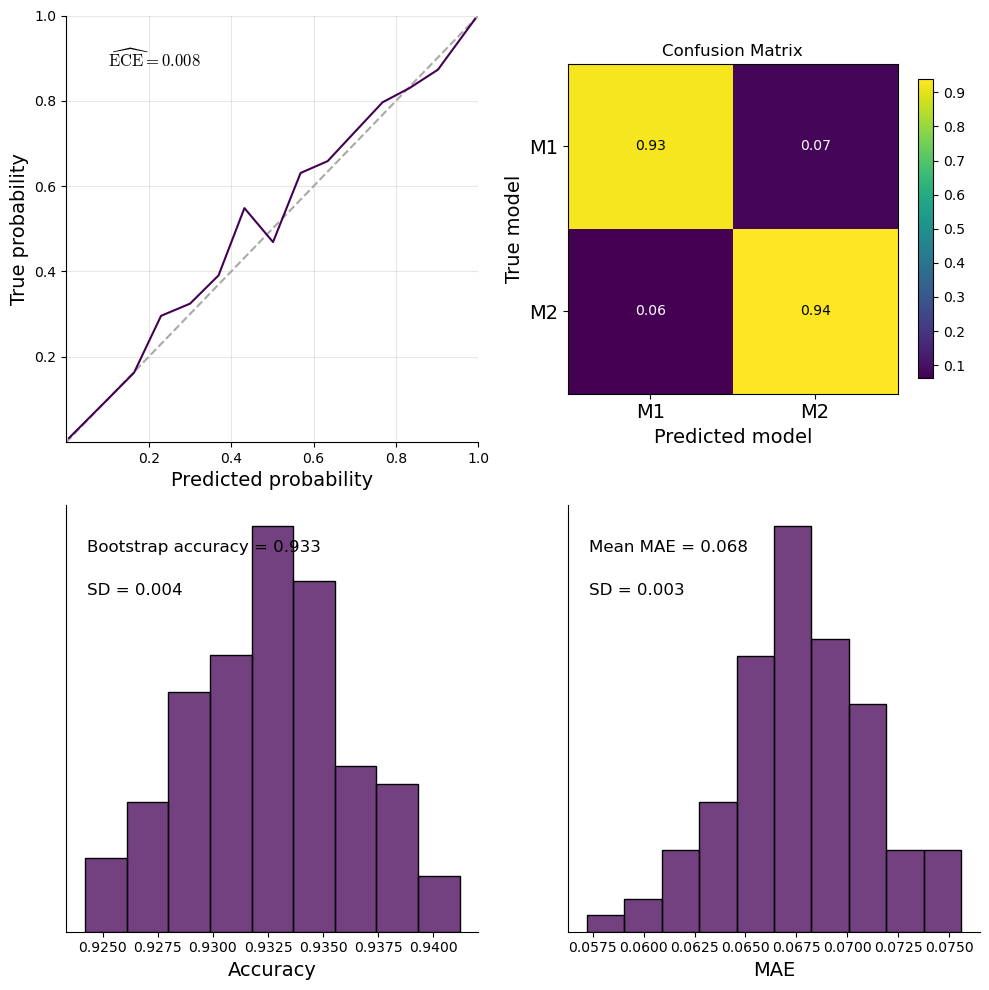

In [7]:
# Test performance
val_data = trainer.configurator(meta_model(5000))
perf_tester(probability_net, summary_net, val_data, n_cal_bins=15)

Median ECE = 0.010274370998110662
Median accuracy = 0.9308


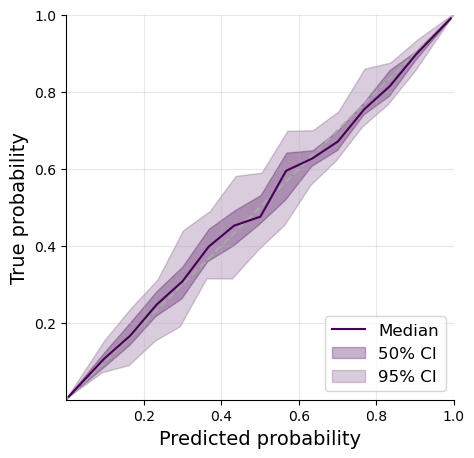

In [8]:
# Plot calibration with repetition uncertainty
n_repetitions = 25

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
m_true_r, m_soft_r = get_repeated_predictions(
    probability_net,
    summary_net,
    trainer,
    meta_model,
    n_models=2,
    n_repetitions=n_repetitions,
)

plot_calibration_curve_repetition_uncertainty(
    m_true_r[:, :, 1],
    m_soft_r[:, :, 1],
    narrow_ci=[0.25, 0.75],
    wide_ci=[0.025, 0.975],
    n_bins=15,
    ax=ax,
    print_accuracy=True,
    xlabel=True,
    ylabel=True,
    title=None,
    show_ece=True,
    show_legend=True,
)

fig.savefig("calibration_SDTMPT.pdf", dpi=300, bbox_inches="tight")

In [12]:
# Save training meta-information for bridge sampling comparison?
# (so that network can be loaded from checkpoint)
save_training_vars = True

if save_training_vars:
    folder = os.path.join(
        os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),
        "data",
        "02_bridge_sampling_comparison",
        "non_nested_models",
    )

    np.save(
        os.path.join(folder, "training_time_start"),
        training_time_start,
        allow_pickle=True,
    )
    np.save(
        os.path.join(folder, "training_time_stop"),
        training_time_stop,
        allow_pickle=True,
    )
    np.save(os.path.join(folder, "losses"), losses, allow_pickle=True)

# Calculate Bayes factors for bridge sampling comparison

In [ ]:
# Import training meta-information?
# (use if network was loaded from checkpoint)
import_training_vars = False

if import_training_vars:
    folder = os.path.join(
        os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),
        "data",
        "01_calibration_validation",
        "03_variable",
    )

    training_time_start = np.load(
        os.path.join(folder, "training_time_start.npy"), allow_pickle=True
    )
    training_time_stop = np.load(
        os.path.join(folder, "training_time_stop.npy"), allow_pickle=True
    )
    losses = np.load(os.path.join(folder, "losses.npy"), allow_pickle=True)

In [9]:
# Import test data
val_folder = os.path.join(
    os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),
    "data",
    "02_bridge_sampling_comparison",
    "non_nested_models",
)
data_filename = "test_data.npy"
test_data = np.load(os.path.join(val_folder, data_filename), allow_pickle=True).item()

In [10]:
# Get NN predictions
comparison_results = get_preds_and_bfs(
    probability_net,
    summary_net,
    test_data,
    training_time_start,
    training_time_stop,
    losses,
)
comparison_results.head(5)

c:\Users\lasse\projects\hierarchical_model_comparison\src\python\helpers.py:369: RuntimeWarning: divide by zero encountered in divide
  bayes_factor = m1_prob / m0_prob


,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.986348,1.365247e-02,0,1.384144e-02,3272.36167,0.002102,0.158629
1,2,0,0.974817,2.518262e-02,0,2.583317e-02,3272.36167,0.002102,0.158629
2,3,0,1.000000,6.694834e-16,0,6.694834e-16,3272.36167,0.002102,0.158629
3,4,1,0.205285,7.947150e-01,1,3.871276e+00,3272.36167,0.002102,0.158629
4,5,0,0.999760,2.395562e-04,0,2.396136e-04,3272.36167,0.002102,0.158629


In [11]:
# Export results
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime("%Y_%m_%d_BF_NN")
comparison_folder = os.path.join(
    os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),
    "data",
    "02_bridge_sampling_comparison",
    "non_nested_models",
)

comparison_results.to_csv(os.path.join(comparison_folder, filename), index=False)